In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
from skimage.util import invert
from skimage.io import imread, imsave
from scipy.ndimage import gaussian_filter
import seaborn as sns
from matplotlib import pyplot as plt

from chromemt_analysis import segment_like_paper, continuous_erosion_edt, linear_fit_to_residual_volume, parse_simulation_zip

## Perform analysis on both simulated patches and ChromEMT and compare

In [2]:
# id, zipfile, file in zipfile

simulation_data = [
    ('sim_irregular_390', '/Volumes/davidh-ssd/chromemt_data/simulations/VoxelTest.zip', None ),
    ('sim_regular_390', '/Volumes/davidh-ssd/chromemt_data/simulations/VoxelTestReg.zip', None ),
    ('sim_inactive_cd_415', '/Volumes/davidh-ssd/chromemt_data/simulations/voxelVersion415.zip', 'voxeltestInactiveCD.dat' ),
    ('sim_irregular_415', '/Volumes/davidh-ssd/chromemt_data/simulations/voxelVersion415.zip', 'voxeltestIrr.dat' ),
    ('sim_regular_415', '/Volumes/davidh-ssd/chromemt_data/simulations/voxelVersion415.zip', 'voxeltestReg.dat' )
]

# load all simulations, invert
simulated_images = {id_: invert(parse_simulation_zip(zip_, subfile)[1].astype(np.float32)) for id_, zip_, subfile in simulation_data} 

In [3]:
# save some simulated data as tiff
imsave('/Volumes/davidh-ssd/chromemt_data/simulations/InactiveCDSim.tif', np.expand_dims(simulated_images['sim_inactive_cd_415'],1))

In [3]:
def cut_central_patches(img, patch_size=94):

    n_patches = [s // patch_size for s in img.shape]
    offset = [s % patch_size // 2 for s in img.shape]

    cut_starts = np.stack(np.meshgrid(*[np.arange(off, off+n*patch_size, patch_size) for off, n in zip(offset, n_patches)], indexing='ij'), -1).reshape(-1, 3)
    cuts = [img[tuple([slice(csi, csi+patch_size) for csi in cs])] for cs in cut_starts]

    return cuts

simulated_patches = {id_: cut_central_patches(img) for id_, img in simulated_images.items()}

In [4]:
pixel_size = 1.28
tile_size_nm = 120.0
tile_size = int( np.ceil( tile_size_nm / pixel_size ))

patches_chromemt = {}

chromemt_img = imread('/Volumes/davidh-ssd/chromemt_data/49801.tif')
n_tiles = (1, 8, 8)
tile_offsets = ((chromemt_img.shape[0] - tile_size) // 2 , 150, 50)

cut_starts = np.meshgrid(*(np.arange(tile_offsets_i, tile_offsets_i + n_tiles_i * tile_size, tile_size ) for tile_offsets_i, n_tiles_i in zip(tile_offsets, n_tiles)), indexing='ij')
cut_starts = np.stack(cut_starts, -1)
cut_starts = cut_starts.reshape((np.prod(n_tiles), -1))

patches_chromemt['real_chromemt_interphase'] = [chromemt_img[tuple(slice(c, c+tile_size) for c in cut_start)] for cut_start in cut_starts]

chromemt_img = imread('/Volumes/davidh-ssd//chromemt_data/49803.tif')
n_tiles = (1, 6, 6)
tile_offsets = ((chromemt_img.shape[0] - tile_size) // 2 , 310, 130)

cut_starts = np.meshgrid(*(np.arange(tile_offsets_i, tile_offsets_i + n_tiles_i * tile_size, tile_size ) for tile_offsets_i, n_tiles_i in zip(tile_offsets, n_tiles)), indexing='ij')
cut_starts = np.stack(cut_starts, -1)
cut_starts = cut_starts.reshape((np.prod(n_tiles), -1))

patches_chromemt['real_chromemt_mitotic'] = [chromemt_img[tuple(slice(c, c+tile_size) for c in cut_start)] for cut_start in cut_starts]

In [5]:
sigma = 2
res = defaultdict(list)

for id_, patches in simulated_patches.items():
    for patch in patches:
        patch = gaussian_filter(patch, sigma)
        mask = segment_like_paper(patch)
        cvc = mask.sum() / mask.size

        erosion_radii = np.arange(1, 11)
        trace = continuous_erosion_edt(mask)
        est_diam, _ = linear_fit_to_residual_volume(trace, erosion_radii)

        res['id'].append(id_)
        res['cvc'].append(cvc)
        res['diam'].append(est_diam)

In [6]:
for id_, patches in patches_chromemt.items():
    for patch in patches:
        mask = segment_like_paper(patch)
        cvc = mask.sum() / mask.size

        erosion_radii = np.arange(1, 11)
        trace = continuous_erosion_edt(mask)
        est_diam, _ = linear_fit_to_residual_volume(trace, erosion_radii)

        res['id'].append(id_)
        res['cvc'].append(cvc)
        res['diam'].append(est_diam)

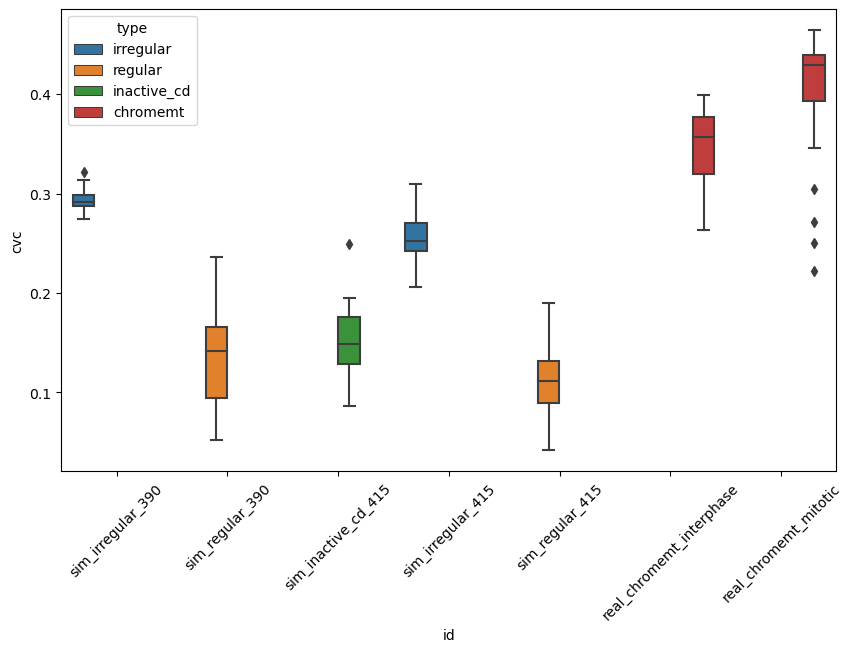

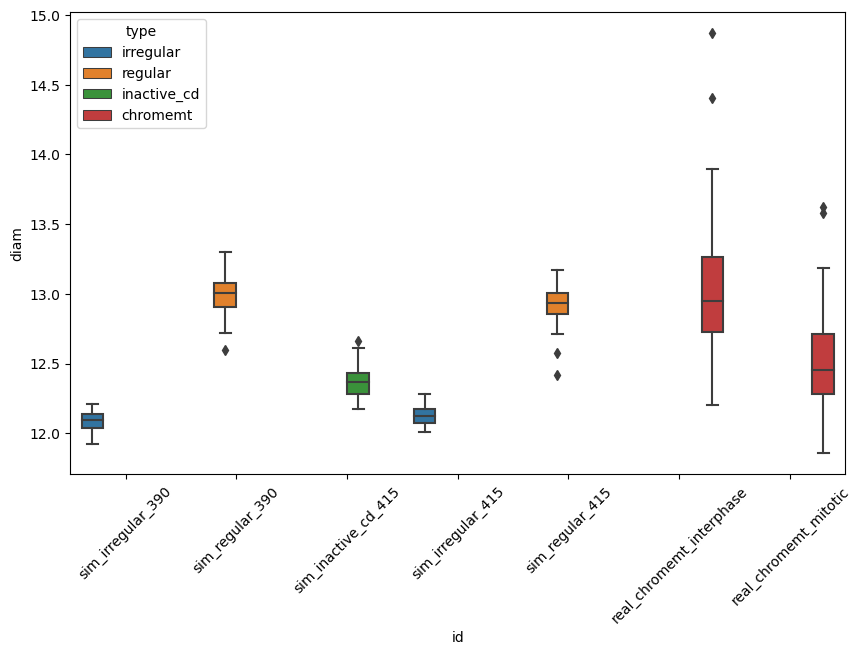

In [7]:
df = pd.DataFrame.from_dict(res)
df['diam'] *= 1.28
df['type'] = df.id.str.split('_', n=1, expand=True)[1].str.rsplit('_', n=1, expand=True)[0]

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(ax=ax, data=df, x='id', y='cvc', hue='type')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(ax=ax, data=df, x='id', y='diam', hue='type')
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);